In [126]:
import time

import pandas as pd
import numpy as np

import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm
import glob
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

In [82]:
# NLP libs
import re
import nltk
from nltk import word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import transformers
import spacy
import simplemma
import flair
import gcld3
from flair.data import Sentence
from syntok.tokenizer import Tokenizer
import gensim
import gensim.corpora as corpora
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.ldamodel import LdaModel
import sentence_transformers
from wordcloud import WordCloud
from sklearn.feature_extraction.text import *
from sklearn.decomposition import LatentDirichletAllocation, NMF

import pyLDAvis
import pyLDAvis.sklearn

In [3]:
lang_detector = gcld3.NNetLanguageIdentifier(min_num_bytes=0,
                                        max_num_bytes=800)

In [4]:
csv_files = glob.glob('../data/*/*.csv')
len(csv_files)

10

In [5]:
clear_string = lambda x: re.sub(' +', ' ',
                                re.sub('https?:\/\/.+\s', ' [URL] ',
                                       re.sub('<.*?>', ' ', str(x))
                                       .replace("&nbsp;", "")
                                       .replace("&rsquo;", "'")
                                       .replace("&amp;", "&")
                                       .replace("\u202f", " ")
                                       .replace("\xa0", " ")
                                       .replace("&mdash;", "-")
                                       .replace('.', '. ')
                                       .replace('\t', ' ')
                                       .replace("•", "-")
                                       .replace("●", "-")
                                       .replace('\n', ' ')
                                       ).replace('/', ' / ').replace('\\', ' \ ').replace('|', ' | ')
                                ).strip()

In [6]:
skip_companies_for_erge = []

In [7]:
def tokenize_text(text: str, lemmatize = True, tokenizer = Tokenizer()) -> list:
    tokens = [token.value for token in tokenizer.tokenize(text)]
    if lemmatize:
        tokens = [simplemma.lemmatize(token, ('ru', 'en', 'fr', 'de')) if simplemma.is_known(token, ('ru', 'en', 'fr', 'de')) else token for token in tokens if token]
    return tokens

In [8]:
def vectorizer_preprocess(text: str) -> str:
    return re.sub(r'\d+|[+.;,:!?}{^№=><)(\\/&*$%#]', '', text).replace("--", '-').strip().lower()

## Пост-обработка csv файлов и создание excel

In [73]:
for file in tqdm(csv_files):

    file_name = file.rsplit('.', 1)[0]
    compnany_name = file.split('/')[2]
    df = pd.read_csv(file, index_col=0, lineterminator='\n')

    if compnany_name not in skip_companies_for_erge:

        df['title'] = df['title'].apply(clear_string)
        df['description'] = df['description'].fillna('N/A').apply(clear_string)
        df['responsibilities'] = df['responsibilities'].fillna('N/A').apply(clear_string)
        df['qualifications'] = df['qualifications'].fillna('N/A').apply(clear_string)

        df.replace('N / A', None, inplace=True)
        df.to_csv(file_name + '.csv', line_terminator='\n')

    df.to_excel(file_name + '.xlsx', engine='xlsxwriter')

100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


## Merging

In [9]:
data_frames = []
for file in tqdm(csv_files):
    file_name = file.rsplit('.', 1)[0]
    compnany_name = file.split('/')[2]

    df = pd.read_csv(file, index_col=0, lineterminator='\n')

    if compnany_name not in skip_companies_for_erge:
        data_frames.append(df[['title', 'description', 'responsibilities', 'qualifications', 'company' ,'publish_date']])

merged_dataset = pd.concat(data_frames)
merged_dataset.info()

100%|██████████| 10/10 [00:01<00:00,  7.87it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48162 entries, 0 to 9042
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             48162 non-null  object
 1   description       45402 non-null  object
 2   responsibilities  37386 non-null  object
 3   qualifications    47452 non-null  object
 4   company           48162 non-null  object
 5   publish_date      47375 non-null  object
dtypes: object(6)
memory usage: 2.6+ MB


In [10]:
merged_dataset['company'].value_counts()

IBM             13203
Amazon           9998
Apple            9043
Microsoft        7553
Google           4766
Tencent          2010
Yandex            787
Alibaba           267
YouTube           239
Tinkoff           161
Fitbit             93
DeepMind           40
Google Fiber        2
Name: company, dtype: int64

In [11]:
merged_dataset.sample(15)

title  \
4222                Senior UX Engineer, Design, Android   
16                                           ML-инженер   
815                    Senior Technical Program Manager   
8996  Program Execution Specialist, Federal Delivery...   
7458                         Security Software Engineer   
286             Manufacturing Test Development Engineer   
7262  Motion / Location Sensing Engineering Program ...   
3573  Manager, Corporate Real Estate Lease Administr...   
364       [IJDS] IT Specialist / Application Programmer   
3366         Senior UX Researcher, Devices Design Group   
5     Инженер по тестированию мобильных приложений в...   
5193                                  Z Cloud Developer   
25              Sr. Site Reliability Engineer(Tech Ops)   
4226                   Digital Customer Success Manager   
6847                               Full Stack Developer   

                                            description  \
4222  At Google, we follow a simple but vital premis...   
16    Вакансия для тех, кто хочет заниматься разрабо...   
815   Azure Edge + Platform brings together Edge pla...   
8996  Job summary Amazon Web Services (AWS) is the l...   
7458  Software Developers at IBM are the backbone of...   
286   We are a team of Manufacturing Test Engineers ...   
7262  In this critical role, you will play a key par...   
3573  Do you love working in a complex, global, inte...   
364   As an Application Developer, you will lead IBM...   
3366  Job summary The Amazon Device and Services Des...   
5     Яндекс. Плюс — это единая подписка на сервисы ...   
5193  Software Developers at IBM are the backbone of...   
25                                                  NaN   
4226  Microsoft is on a mission to empower every per...   
6847  As an Application Developer, you will lead IBM...   

                                       responsibilities  \
4222  Deliver innovative, engaging prototypes using ...   
16    Изучение научных статей, генерирование гипотез...   
815   Responsibilities include connecting with users...   
8996                                                NaN   
7458  IBM is searching for self-motivated Security S...   
286   Collaborate with EE and Systems Engineering du...   
7262  - Lead and align cross-functional teams includ...   
3573  - Lead Apple’s Lease Administration team, incl...   
364                   Refer to Japanese Job Description   
3366                                                NaN   
5     Что нужно делать : заниматься функциональным т...   
5193  You need to have good skills in the areas of s...   
25    Description: You are to work with a cross-func...   
4226  Build and lead a high-performing, diverse team...   
6847  This job role specialty is focused on the deli...   

                                         qualifications    company  \
4222  Minimum qualifications: Bachelor's degree in E...     Google   
16    Опыт разработки моделей машинного обучения с и...    Tinkoff   
815   Required Qualifications: 5+ years experience w...  Microsoft   
8996  2+ years in delivering results for government ...     Amazon   
7458  Extended experience on agile methodology Bache...        IBM   
286   Minimum qualifications: Bachelor's degree in E...     Google   
7262  Product development / engineering experience a...      Apple   
3573  Strong leadership skills with the ability to e...      Apple   
364                   Refer to Japanese Job Description        IBM   
3366  7+ years of experience in the field of UX rese...     Amazon   
5     Мы ждем , что вы : тестировали мобильные прило...     Yandex   
5193  Bachelor's Degree in Computer Science or relat...        IBM   
25    -Minimal Requirements BS. or advanced degrees ...    Tencent   
4226  Required / Minimum Qualifications Bachelor's D...  Microsoft   
6847  Meaningful development experience in modern we...        IBM   

                          publish_date  
4222  2022-05-10 19:05:24.180000+00:00  
16    2018-0

## Аналитика

In [12]:
nan_replaced = merged_dataset.fillna('')
merged_dataset['merged_info'] = nan_replaced['title']+ ' ; ' + nan_replaced['description'] + ' ; ' + nan_replaced['responsibilities'] + ' | ' + nan_replaced['qualifications']

In [13]:
merged_dataset['language'] = merged_dataset['merged_info'].apply(lambda x: lang_detector.FindLanguage(x).language)

In [14]:
px.bar(data_frame=merged_dataset['language'].value_counts(), log_y=True, title='Языки вакансий')

In [15]:
list(enumerate(merged_dataset['description'].sample(5)))

[(0,
  'The Finance & Admin Business Analyst is essential to the ongoing profitable operations for one of the most globally recognized and respected companies in the world. By overseeing our financial activities, you will enable IBM to continue to bring to market ground-breaking innovations such as Artificial Intelligence, Cognitive Solutions, Cloud Infrastructure, and Blockchain technologies, to name a few.'),
 (1,
  'Marcom is Apple’s Global Marketing Communications group. We oversee all of Apple’s advertising and marketing to ensure the flawless development and execution of world-class customer experiences. The Interactive Retail team is recruiting an associate producer. This person will support digital marketing projects for the web and email. In this role, you will work on updates to consumer-facing product marketing pages as well as updates and improvements for the web. In this role, you will collaborate with internal creative and development teams, as well as with partners from 

In [16]:
fig = make_subplots(rows=4, x_title='Количество слов')
fig.add_histogram(x=merged_dataset['description'].dropna().apply(lambda x: x.split()).apply(len), row=1, col=1, name='description')
fig.add_histogram(x=merged_dataset['responsibilities'].dropna().apply(lambda x: x.split()).apply(len), row=2, col=1, name='responsibilities')
fig.add_histogram(x=merged_dataset['qualifications'].dropna().apply(lambda x: x.split()).apply(len), row=3, col=1, name='qualifications')
fig.add_histogram(x=merged_dataset['merged_info'].dropna().apply(lambda x: x.split()).apply(len), row=4, col=1, name='merged')
fig.update_layout(title_text='Длины текстовых полей (кол-ва слов)', bargap=0.2)
fig.show()

In [18]:
total_stopwords = set(stopwords.words(['english', 'german', 'french', 'russian']))
len(total_stopwords)

701

In [19]:
c_vectorizer = CountVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 1), tokenizer=tokenize_text, preprocessor=lambda x: vectorizer_preprocess(x), stop_words=total_stopwords)
hot_matrix = c_vectorizer.fit_transform(merged_dataset['merged_info'].dropna())
hot_matrix.shape

/home/hivaze/miniconda3/envs/text/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'s", 'Aren', 'No', 'avion', 'avoir', 'could', 'diesis', 'eat', 'er|es|sie', 'fuss', 'jed', 'jen', 'mama', 'manch', 'mettre', 'might', 'must', 'müssen', 'need', 'pa', 'r', 'serum', 'sha', 'solch', 'sollen', 'somme', 'welch', 'would', 'à les', 'étai', 'étion', 'être', 'бздеть', 'большой', 'быль', 'весь', 'двух', 'житься', 'конечный', 'многий', 'мочь', 'мыть', 'посол', 'пот', 'почтить', 'свой', 'така', 'тема', 'тереть', 'тута', 'хороший'] not in stop_words.



(48162, 32337)

In [20]:
np_matrix = np.array(-hot_matrix.sum(0)).squeeze()
top_tokens = pd.DataFrame(c_vectorizer.get_feature_names_out()[np.argsort(np_matrix)]).rename({0: 'token'}, axis=1)
top_tokens['freq'] = -np.sort(np_matrix)
px.bar(x=top_tokens.iloc[:50]['token'], y=top_tokens.iloc[:50]['freq'], title="Топ 50 слов во всех вакансиях")

In [21]:
top_tokens.head(100)

token    freq
0   experience  214070
1         team  196064
2         work  157445
3     customer  152795
4     business  129324
..         ...     ...
95         one   23853
96    delivery   23630
97    identify   23625
98        base   23624
99       issue   23435

[100 rows x 2 columns]

In [22]:
tf_idf_matrix = TfidfTransformer().fit_transform(hot_matrix)
tf_idf_matrix.shape

(48162, 32337)

## Классическое тематическое моделирование

In [182]:
def show_topics(model, feature_names, n_words=10):
    keywords = np.array(feature_names)
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))

    topics_popularity_dict = Counter(nmf_result.argmax(1))
    topic_doc_counts = [topics_popularity_dict[i] for i in range(100)]

    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    df_topic_keywords.insert(0, 'Popularity', topic_doc_counts)

    return df_topic_keywords

In [189]:
def plot_topic(topics_df, topic_num):
    fig = plt.figure(figsize=(10, 8))
    fig.patch.set_facecolor('white')
    plt.imshow(WordCloud(width=1000, background_color='white', max_font_size=60, height=800)
               .generate_from_text(" ".join(topics_df.iloc[topic_num].values[1:])), interpolation="bilinear")

#### LSA (NMF на tf-idf)

In [96]:
nmf_model = NMF(n_components=100, verbose=1, max_iter=150)
nmf_result = nmf_model.fit_transform(tf_idf_matrix)
nmf_model.components_.shape, nmf_result.shape

violation: 1.0
violation: 0.16114364606259432
violation: 0.11764493509553543
violation: 0.08306254407875063
violation: 0.06277242577248855
violation: 0.04956211896505959
violation: 0.03780144216152552
violation: 0.02826979870332377
violation: 0.02187672145626616
violation: 0.017284687234759503
violation: 0.013900206567632115
violation: 0.011312065226071248
violation: 0.009413657397173139
violation: 0.008085572420423494
violation: 0.007096599270178174
violation: 0.006325523943631515
violation: 0.005696314798470794
violation: 0.0051613151092434134
violation: 0.004672680720352639
violation: 0.00420375068218966
violation: 0.0038100558435860124
violation: 0.003501547240736098
violation: 0.003303099120687814
violation: 0.003176101114989444
violation: 0.003078522470558844
violation: 0.002948380756695788
violation: 0.0027796983802469083
violation: 0.00257905031402351
violation: 0.0024025428726418604
violation: 0.0022576565974138387
violation: 0.0021413708632415786
violation: 0.0020619819500017

/home/hivaze/miniconda3/envs/text/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 150 reached. Increase it to improve convergence.



((100, 32337), (48162, 100))

In [186]:
topics = show_topics(nmf_model, c_vectorizer.get_feature_names_out(), n_words=30)
topics.to_csv('../results/nmf-100-topics.csv', index_label='topic')
topics

Popularity         Word 0       Word 1       Word 2        Word 3  \
Topic 0           14       customer         need      service       success   
Topic 1          615            Ibm         code       system     developer   
Topic 2          948              ；            ）            （            深圳   
Topic 3         1039      Microsoft        check   background         cloud   
Topic 4          602       software       design  development  architecture   
...              ...            ...          ...          ...           ...   
Topic 95         622             Ar           vr      reality       augment   
Topic 96         260      mainframe           db            z         cobol   
Topic 97         381              ）            （            ・             ※   
Topic 98         947  modernization  application          net         cloud   
Topic 99         462          apple   specialist      product      reseller   

               Word 4         Word 5     Word 6                  Word 7  \
Topic 0          help     experience       team                solution   
Topic 1   application      limitless      vital               customize   
Topic 2             》              《  csig全资子公司  通过腾讯云从业资格证或同等资格认证的优先录取   
Topic 3   requirement        require   security                  screen   
Topic 4      engineer     experience       less                language   
...               ...            ...        ...                     ...   
Topic 95     engineer            tdg    graphic              technology   
Topic 96         cics            zos        ims             application   
Topic 97            ■              」          「                      jp   
Topic 98    container  microservices     devops              experience   
Topic 99     customer              ’       need                     get   

               Word 8  ...                Word 20                  Word 21  \
Topic 0        facing  ...                helping                    focus   
Topic 1          path  ...                   come                     hand   
Topic 2            上海  ...  通过腾讯云技术认证或同等资格认证的优先录取                     和平精英   
Topic 3    government  ...                   hire               datacenter   
Topic 4       program  ...                    new             professional   
...               ...  ...                    ...                      ...   
Topic 95  interactive  ...                   team                 platform   
Topic 96   experience  ...                   year                   relate   
Topic 97            [  ...        整理整頓、清掃、備品の補充など  ①梱包済み商品以下、荷物と記載の受付、荷下ろし   
Topic 98       hybrid  ...              architect             architecture   
Topic 99        right  ...           relationship                 outstand   

                   Word 22          Word 23                 Word 24  \
Topic 0              build     relationship                   value   
Topic 1         enterprise           future                  leader   
Topic 2               csig                ：                     精通c   
Topic 3              every          include                     coi   
Topic 4                Non             team                    java   
...                    ...              ...                     ...   
Topic 95               ios         creative                    next   
Topic 96             bring         exposure               developer   
Topic 97              最大kg  kg程度の荷物をロールボックス  棚に配置している仕分け用バッグを引き出す動作   
Topic 98  containerization        openshift                  server   
Topic 99           deliver         solution                   match   

                     Word 25                               Word 26  \
Topic 0               ensure                               journey   
Topic 1               design                           development   
Topic 2                熟悉tcp  具备良好的分析解决问题能力，良好的学习和分享习惯，工作积极主动，责任心强   
Topic 3              ability                                  role   
Topic 4             

In [187]:
topics.iloc[10:40]

Popularity         Word 0      Word 1          Word 2  \
Topic 10         585          datum   analytics             big   
Topic 11        1043              ·   associate            site   
Topic 12         176  configuration        test   functionality   
Topic 13         531        project       scope      management   
Topic 14         730           bull   Microsoft            cens   
Topic 15        1360           test  automation        automate   
Topic 16         316         design       power          timing   
Topic 17         315           trac  regulatory          report   
Topic 18         207         system     service           scale   
Topic 19         447              、           ；       csig全资子公司   
Topic 20         467        attempt         era       something   
Topic 21           6          cloud    platform  infrastructure   
Topic 22         506              -     tencent             job   
Topic 23         194              。           ：               ，   
Topic 24          40           team   operation      management   
Topic 25         499       engineer    software          google   
Topic 26         714       security      threat          secure   
Topic 27         136        program     manager      management   
Topic 28         378    advertising      agency          client   
Topic 29         241             ux      design            user   
Topic 30         140     accounting        cash            fixe   
Topic 31         178        machine       learn              ml   
Topic 32         129          azure    platform             sql   
Topic 33           4        support       issue       technical   
Topic 34         204             aw     service             web   
Topic 35          64      technical    solution       architect   
Topic 36          52          sales  specialist            sell   
Topic 37         543            sap        hana            abap   
Topic 38         300        package  consultant       integrate   
Topic 39          88          store      retail            shop   

                  Word 3                 Word 4         Word 5  \
Topic 10       warehouse                 hadoop          spark   
Topic 11         include                  audit        summary   
Topic 12  implementation                    sap  specification   
Topic 13         manager                 manage           cost   
Topic 14      experience                  every   organization   
Topic 15         quality                     qa           case   
Topic 16         circuit                    soc           chip   
Topic 17        delivery                  trade     investment   
Topic 18      distribute               engineer        storage   
Topic 19             Nan  注：此岗位为腾讯集团旗下全资子公司编制岗位             xr   
Topic 20           never                 invent             's   
Topic 21      enterprise             technology       solution   
Topic 22            plus         responsibility       glowroad   
Topic 23               （                      】              【   
Topic 24         process                manager    operational   
Topic 25     information                   code         design   
Topic 26   vulnerability               incident     compliance   
Topic 27           cross                  drive     experience   
Topic 28          medium                   grow        digital   
Topic 29        designer             experience    interaction   
Topic 30         finance                  asset             rr   
Topic 31           model              scientist      algorithm   
Topic 32       Microsoft                service     experience   
Topic 33    troubleshoot                provide     resolution   
Topic 34       migration                compute          cloud   
Topic 35    architecture             technology    engineering   
Topic 36            deal                 seller        revenue   
Topic 37          object             experience             mm   
Topic 38        bu

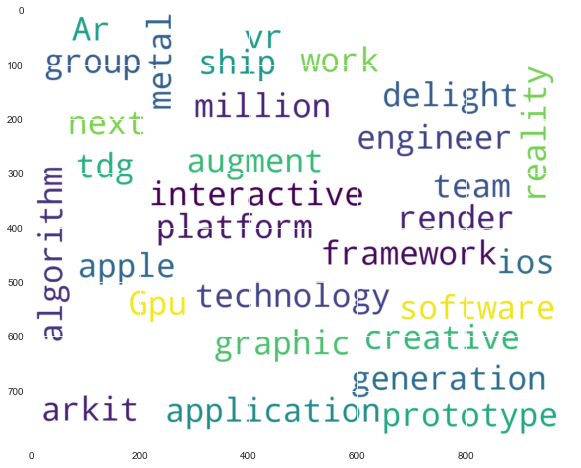

In [190]:
plot_topic(topics, 95)

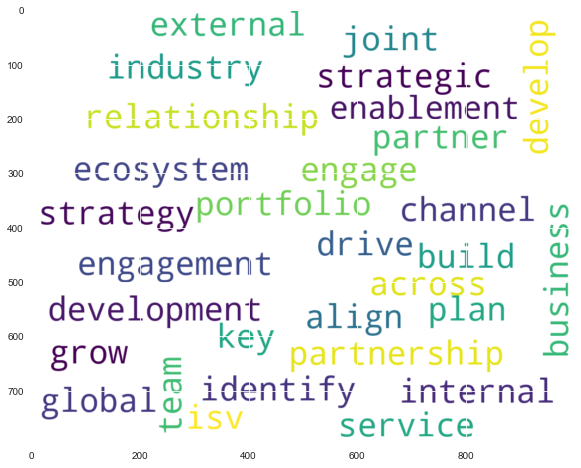

In [191]:
plot_topic(topics, 55)

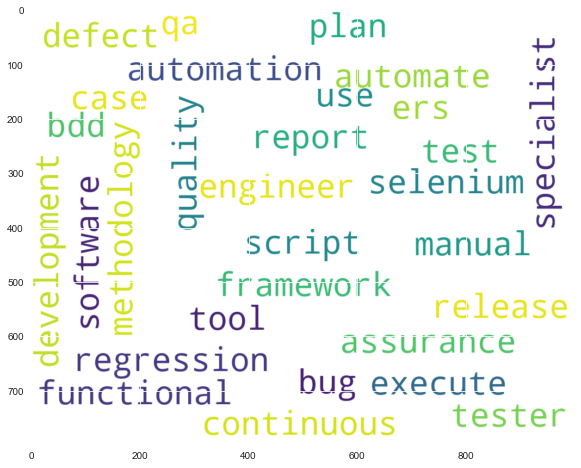

In [192]:
plot_topic(topics, 15)

#### LDA (на TF)

In [208]:
lda_model = LatentDirichletAllocation(n_components=150,               # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      random_state=124,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = 5,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 10,               # Use all available CPUs
                                      verbose=1
                                     )

In [ ]:
lda_output = lda_model.fit_transform(hot_matrix)
lda_output.shape

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20, perplexity: 667.0514
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 639.3505
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20


In [198]:
print("Log Likelihood: ", lda_model.score(hot_matrix))
print("Perplexity: ", lda_model.perplexity(hot_matrix))

Log Likelihood:  -88721283.8522954
Perplexity:  649.5411020370636


In [199]:
topics = show_topics(lda_model, c_vectorizer.get_feature_names_out(), n_words=30)
topics.to_csv('../results/lda-100-topics.csv', index_label='topic')
topics

Popularity          Word 0      Word 1       Word 2        Word 3  \
Topic 0           14       technical    customer     solution     Microsoft   
Topic 1          615  transformation      change   consultant      business   
Topic 2          948               -      health         work       support   
Topic 3         1039           cloud  experience  application    kubernetes   
Topic 4          602            team       apple     software      engineer   
...              ...             ...         ...          ...           ...   
Topic 95         622            team        work           aw          life   
Topic 96         260         content       video     creative          work   
Topic 97         381        customer  experience         team  professional   
Topic 98         947            test     quality   automation          tool   
Topic 99         462           apple       store     customer       product   

              Word 4      Word 5      Word 6      Word 7         Word 8  ...  \
Topic 0   technology       cloud     partner       azure   architecture  ...   
Topic 1        drive         Ibm        part  experience   continuously  ...   
Topic 2      provide    maintain  management         job     experience  ...   
Topic 3     solution    platform     service   container         devops  ...   
Topic 4         work  experience  technology     product        feature  ...   
...              ...         ...         ...         ...            ...  ...   
Topic 95     balance      member     culture  experience          learn  ...   
Topic 96        team  production  experience      medium  communication  ...   
Topic 97        work     service     project          aw           life  ...   
Topic 98    software  experience        team    engineer           work  ...   
Topic 99          ’s        team     service         ’ll        deliver  ...   

              Word 20    Word 21         Word 22        Word 23     Word 24  \
Topic 0    management  spitshine  infrastructure    information        lead   
Topic 1     knowledge   adoption         company           lead  management   
Topic 2        report       must             whs          event     include   
Topic 3   development        use          hybrid         docker   migration   
Topic 4        strong     design            help       building     quality   
...               ...        ...             ...            ...         ...   
Topic 95      service        new            help        diverse      within   
Topic 96       across       edit       including  entertainment      ensure   
Topic 97         lead       earn            base          cloud   technical   
Topic 98      product     report             bug          debug     process   
Topic 99        learn   employee         support              —         app   

              Word 25        Word 26     Word 27     Word 28        Word 29  
Topic 0       achieve     engagement     preferr    practice          build  
Topic 1   development           span    innovate        know           unit  
Topic 2          risk        medical  specialist   workplace           care  
Topic 3            ci  microservices    security        year           base  
Topic 4         build      framework          ’s      across  communication  
...               ...            ...         ...         ...            ...  
Topic 95        group           lead   including      commit        support  
Topic 96  environment           well         art        high         studio  
Topic 97         help          learn      career     develop           role  
Topic 98        issue         python   assurance  understand    methodology  
Topic 99      ability        provide      strong        part        develop  

[100 rows x 31 columns]

In [200]:
panel = pyLDAvis.sklearn.prepare(lda_model, hot_matrix, c_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, '../results/lda-100-topics.html')

/home/hivaze/miniconda3/envs/text/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/home/hivaze/miniconda3/envs/text/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/home/hivaze/miniconda3/envs/text/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/hivaze/miniconda3/envs/text/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



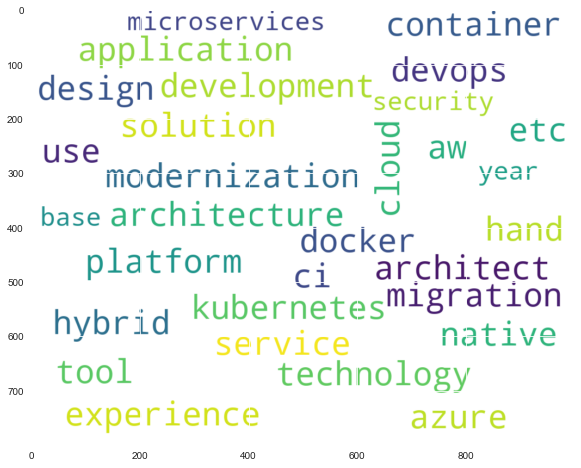

In [201]:
plot_topic(topics, 3)

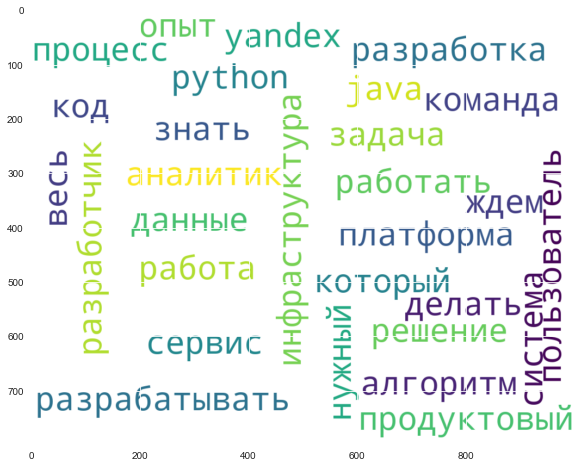

In [207]:
plot_topic(topics, 34)

## Обучение кастомного fasttext

In [114]:
documents = merged_dataset['merged_info'].dropna()
documents = documents.apply(vectorizer_preprocess)
documents = documents.apply(tokenize_text)

In [117]:
documents = documents.apply(lambda x: filter(lambda y: y in c_vectorizer.vocabulary_.keys(), x)).apply(list)

In [121]:
class CustomCallback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.start_time = time.time()

    def on_epoch_begin(self, model):
        print(f'Epoch {self.epoch} beggins after {time.time() - self.start_time} seconds from training start')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1

In [161]:
%%time
ft_model = FastText(sentences=documents, vector_size=150, window=11, sorted_vocab=True, negative=7, workers=10, sg=1, epochs=7, callbacks=[CustomCallback()])

Epoch 0 beggins after 5.454904556274414 seconds from training start
Loss after epoch 0: 0.0
Epoch 1 beggins after 92.41560459136963 seconds from training start
Loss after epoch 1: 0.0
Epoch 2 beggins after 187.9407114982605 seconds from training start
Loss after epoch 2: 0.0
Epoch 3 beggins after 296.8446192741394 seconds from training start
Loss after epoch 3: 0.0
Epoch 4 beggins after 405.65736746788025 seconds from training start
Loss after epoch 4: 0.0
Epoch 5 beggins after 512.6245436668396 seconds from training start
Loss after epoch 5: 0.0
Epoch 6 beggins after 623.5405580997467 seconds from training start
Loss after epoch 6: 0.0
CPU times: user 1h 59min 15s, sys: 12.1 s, total: 1h 59min 27s
Wall time: 12min 14s


In [162]:
ft_model.callbacks = []
ft_model.save('../models/fast-text-11-150.gensim')

In [ ]:
FastText

In [163]:
pd.DataFrame(ft_model.wv.most_similar('trend', topn=30))

0         1
0              emerge  0.649898
1            identify  0.638705
2             insight  0.615480
3             analyze  0.613198
4            vertical  0.586214
5      recommendation  0.578117
6          competitor  0.569102
7           landscape  0.557798
8              inform  0.552023
9   portfoliopipeline  0.550539
10         understate  0.547530
11             devise  0.543587
12          formulate  0.542971
13             metric  0.538404
14          sentiment  0.536354
15         historical  0.533700
16      knowledgebase  0.531341
17            current  0.531091
18            examine  0.530550
19        observation  0.529162
20           relevant  0.526829
21         whitespace  0.525981
22          potential  0.525486
23        implication  0.521869
24        proactively  0.520306
25          instigate  0.519950
26        qualitative  0.517016
27               dive  0.516367
28             marker  0.516335
29             report  0.515297